## `분석주제`

### Import

In [1]:
import numpy as np
import pandas as pd
# preprocess
import osmnx as ox
from haversine import haversine
from sklearn.cluster import KMeans
import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, PowerTransformer
from sklearn.metrics import mean_absolute_error
# modeling
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
# visualize
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
# ignore warnings
import warnings ; warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'osmnx'

### Read Data

In [2]:
train = pd.read_csv('./data/raw/train.csv', parse_dates=['base_date'])
test = pd.read_csv('./data/raw/test.csv', parse_dates=['base_date'])
sample = pd.read_csv('./data/raw/sample_submission.csv')

### 1. EDA

## 2. Data Cleansing

#### [Drop] categorical variable
특정값이 많은 변수는 데이터를 잘 설명하지 못한다. 변수 내 범주빈도를 구한 뒤 가장 큰 범주빈도가 0.95 이상이면 제거한다.

In [3]:
category = ['road_rating', 'road_name', 'multi_linked', 'connect_code', 'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
            'height_restricted', 'road_type', 'start_node_name','start_turn_restricted', 'end_node_name','end_turn_restricted']

In [4]:
category_dense = train[category].apply(lambda x: x.value_counts(normalize=True).iloc[0])

print(f'삭제되는 열은 {category_dense[category_dense > 0.95].index.values} 입니다.')
train.drop(category_dense[category_dense > 0.95].index, axis=1, inplace=True)
test.drop(category_dense[category_dense > 0.95].index, axis=1, inplace=True)

삭제되는 열은 ['multi_linked' 'connect_code' 'vehicle_restricted' 'height_restricted'] 입니다.


- #### [Generation] 거리, 속도, 시간

In [5]:
# 제주도 동,서,남,북 위경도
north = 33 + (33/60) + (50/3600)
south = 33 + (11/60) + (27/3600)
east = 126 + (58/60) + (20/3600)
west = 126 + (8/60) + (43/3600)

G = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')
# fig, ax = ox.plot_graph(G, figsize=(20,20), bgcolor = 'white', node_color='g', save=True, filepath="osmnx_jeju_graph.png")
G = ox.add_edge_speeds(G, {"residential": 35, "secondary": 50, "tertiary": 60})
G = ox.add_edge_travel_times(G)

In [6]:
def between_twopoint(DATA):
    EASE = DATA.drop_duplicates(['start_latitude','start_longitude','end_latitude','end_longitude'])\
           [['start_latitude','start_longitude','end_latitude','end_longitude']]
    UNIQUE = []
    for _, SLAT, SLON, ELAT, ELON in EASE.itertuples():
        orig_node, dest_node = ox.nearest_nodes(G, SLON, SLAT), ox.nearest_nodes(G, ELON, ELAT) 
        if orig_node != dest_node:
            # 최단거리(meter)
            route = ox.shortest_path(G, orig_node, dest_node, weight='length')
            length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))
            # 평균속도
            route = ox.shortest_path(G, orig_node, dest_node, weight='speed_kph')
            speed = np.mean(ox.utils_graph.get_route_edge_attributes(G, route, "speed_kph"))
            # 소요시간
            route = ox.shortest_path(G, orig_node, dest_node, weight='travel_time')
            time = sum(ox.utils_graph.get_route_edge_attributes(G, route, "travel_time"))
        else:
            length, speed, time = haversine((SLAT,SLON),(ELAT,ELON), unit='m') , 0, 0
        UNIQUE.append([SLAT, SLON, ELAT, ELON, length, speed, time])
    RETURN = pd.DataFrame(UNIQUE, columns=['start_latitude','start_longitude','end_latitude','end_longitude','length','speed','time'])
    return RETURN

In [7]:
# 최근 한달 값으로 처리하는 것도 시도하기.
unique_train = between_twopoint(train)
ease = pd.merge(unique_train, train.query('base_date >= "2022-06-15"'), 
                on=['start_latitude','start_longitude','end_latitude','end_longitude'])
length_error = ease.query('speed!=0').groupby('speed')['length'].std().mean()
unique_train['speed'] = unique_train[['length','speed']]\
                       .apply(lambda x: ease.query('@x[0]-@length_error <= length <= @x[0]+@length_error')['speed'].mean() if x[1]==0 else x[1], axis=1)

length_error = ease.query('time!=0').groupby('time')['length'].std().mean()
unique_train['time'] = unique_train[['length','time']]\
                      .apply(lambda x: ease.query('@x[0]-@length_error <= length <= @x[0]+@length_error')['time'].mean() if x[1]==0 else x[1], axis=1)    

In [8]:
unique_test = between_twopoint(test)
ease = pd.merge(unique_test, test, on=['start_latitude','start_longitude','end_latitude','end_longitude'])
length_error = ease.query('speed!=0').groupby('speed')['length'].std().mean()
unique_test['speed'] = unique_test[['length','speed']]\
                       .apply(lambda x: ease.query('@x[0]-@length_error <= length <= @x[0]+@length_error')['speed'].mean() if x[1]==0 else x[1], axis=1)

length_error = ease.query('time!=0').groupby('time')['length'].std().mean()
unique_test['time'] = unique_test[['length','time']]\
                      .apply(lambda x: ease.query('@x[0]-@length_error <= length <= @x[0]+@length_error')['time'].mean() if x[1]==0 else x[1], axis=1)        

In [9]:
train[['length','speed','time']] = pd.merge(train[['id','start_latitude','start_longitude','end_latitude','end_longitude']], 
                                            unique_train, 
                                            on=['start_latitude','start_longitude','end_latitude','end_longitude'], how='left')\
                                   [['length','speed','time']]
test[['length','speed','time']] = pd.merge(test[['id','start_latitude','start_longitude','end_latitude','end_longitude']], 
                                           unique_test, 
                                           on=['start_latitude','start_longitude','end_latitude','end_longitude'], how='left')\
                                  [['length','speed','time']]

- #### [Generation] Cluster

In [10]:
cluster = KMeans(n_clusters=4, random_state=2022).fit(np.vstack((train[['start_latitude','start_longitude']].values, 
                                                                 train[['end_latitude','end_longitude']].values)))

In [11]:
train['start_cluster'] = cluster.predict(train[['start_latitude','start_longitude']].values)
train['end_cluster'] = cluster.predict(train[['end_latitude','end_longitude']].values)
test['start_cluster'] = cluster.predict(test[['start_latitude','start_longitude']].values)
test['end_cluster'] = cluster.predict(test[['end_latitude','end_longitude']].values)

#### [Imputation] road name
'-'는 결측치이다. 출발지점과 도착지점을 정렬한 후 가까운 값으로 대치한다.

In [12]:
# 도로명주소는 노선에 도로명을 부여한 주소이다.
# 외부데이터의 도로명주소 활용방안
# 도로별 데이터수를 구해서 붙이는게 최고일듯

In [13]:
replace = train.sort_values(['start_latitude', 'start_longitude', 'end_latitude','end_longitude'])[['id','road_name']]
fb = replace['road_name'].apply(lambda x: np.nan if x=='-' else x).fillna(method='ffill').fillna(method='backfill')
bf = replace['road_name'].apply(lambda x: np.nan if x=='-' else x).fillna(method='backfill').fillna(method='ffill')

print('ffill 후 backfill하는 방법의 차이:', (train.query('road_name != "-"').road_name.value_counts(normalize=True)\
                                             - fb.value_counts(normalize=True)).std())
print('backfill 후 ffill하는 방법의 차이:', (train.query('road_name != "-"').road_name.value_counts(normalize=True)\
                                             - bf.value_counts(normalize=True)).std())

ffill 후 backfill하는 방법의 차이: 0.002982507702165136
backfill 후 ffill하는 방법의 차이: 0.002328224428765971


In [14]:
train['road_name'] = bf
test['road_name'] = test['road_name'].apply(lambda x: np.nan if x=='-' else x).fillna(method='backfill').fillna(method='ffill')

#### [Labeling] noad name
입구, 교, 교차로/사거리/삼거리, 주택/아파트, 기타로 특성을 구분한다.

In [15]:
# 고려해봄(구현X)

#### [Labeling] node name
node name을 labeling하고 이로써 출발지점, 도착지점의 방향을 고려한 labeling을 시도한다.

In [16]:
# 출발과 도착이 같은 edge_label은 0으로 통일하는 등의 방법도 고려해봄
# print('start=end train:', train.query('start_node_name == end_node_name').shape[0]/train.shape[0])
# print('start=end test:', test.query('start_node_name == end_node_name').shape[0]/test.shape[0])

In [17]:
label_df = pd.concat([train['start_node_name'].rename('node_name'), train['end_node_name'].rename('node_name')]).drop_duplicates()\
           .reset_index(drop=True).reset_index().rename(columns={'index':'node_label'}).set_index('node_name')

for label in pd.concat([test['start_node_name'].rename('node_name'), test['end_node_name'].rename('node_name')]).drop_duplicates():
    if label not in label_df.index:
        label_df.loc[label] = label_df['node_label'].max() + 1

In [18]:
train['start_node_label'] = pd.merge(train[['id','start_node_name']], 
                                     label_df.reset_index().rename(columns={'node_name':'start_node_name'}), 
                                     on='start_node_name', how='left')['node_label']
train['end_node_label'] = pd.merge(train[['id','end_node_name']], 
                                   label_df.reset_index().rename(columns={'node_name':'end_node_name'}), 
                                   on='end_node_name', how='left')['node_label']

In [19]:
test['start_node_label'] = pd.merge(test[['id','start_node_name']], 
                                     label_df.reset_index().rename(columns={'node_name':'start_node_name'}), 
                                     on='start_node_name', how='left')['node_label']
test['end_node_label'] = pd.merge(test[['id','end_node_name']], 
                                   label_df.reset_index().rename(columns={'node_name':'end_node_name'}), 
                                   on='end_node_name', how='left')['node_label']

In [20]:
del train['start_node_name'], train['end_node_name']
del test['start_node_name'], test['end_node_name']

- #### [Labeling] edge

In [21]:
label_df = train[['start_node_label','end_node_label']].drop_duplicates()\
           .reset_index(drop=True).reset_index().rename(columns={'index':'edge_label'}).set_index(['start_node_label','end_node_label'])

for label in test[['start_node_label','end_node_label']].drop_duplicates().values:
    if tuple(label) not in label_df.index:
        label_df.loc[tuple(label), 'edge_label'] = label_df['edge_label'].max()+1

In [22]:
train['edge_label'] = pd.merge(train[['id','start_node_label','end_node_label']], label_df.reset_index(), 
                               on=['start_node_label','end_node_label'], how='left')['edge_label']
test['edge_label'] = pd.merge(test[['id','start_node_label','end_node_label']], label_df.reset_index(), 
                               on=['start_node_label','end_node_label'], how='left')['edge_label']

#### [Labeling] latitude, longitude

In [23]:
label_df = train[['start_latitude','start_longitude','end_latitude','end_longitude']].drop_duplicates()\
           .reset_index(drop=True).reset_index().rename(columns={'index':'coordinate_label'})\
           .set_index(['start_latitude','start_longitude','end_latitude','end_longitude'])

for label in test[['start_latitude','start_longitude','end_latitude','end_longitude']].drop_duplicates().values:
    if tuple(label) not in label_df.index:
        label_df.loc[tuple(label), 'coordinate_label'] = label_df['coordinate_label'].max()+1  

In [24]:
label_df = label_df.reset_index()

# 방향이 반대인 것은 Minus로 labeling한다.
for IDX, SLAT, SLON, ELAT, ELON, COOR in label_df.itertuples():
    CHANGE = label_df.loc[IDX:].query('(start_latitude==@ELAT) & (start_longitude==@ELON) &\
                                       (end_latitude==@SLAT) & (end_longitude==@SLON)').index
    if len(CHANGE)==1:
        label_df.iloc[CHANGE, -1] = -1 * COOR

In [25]:
train['coor_label'] = pd.merge(train[['id','start_latitude','start_longitude','end_latitude','end_longitude']], label_df, 
                               on=['start_latitude','start_longitude','end_latitude','end_longitude'], how='left')['coordinate_label']
test['coor_label'] = pd.merge(test[['id','start_latitude','start_longitude','end_latitude','end_longitude']], label_df, 
                              on=['start_latitude','start_longitude','end_latitude','end_longitude'], how='left')['coordinate_label']

In [26]:
display(train.isna().sum()/train.shape[0])
display(test.isna().sum()/test.shape[0])

id                       0.0
base_date                0.0
day_of_week              0.0
base_hour                0.0
lane_count               0.0
road_rating              0.0
road_name                0.0
maximum_speed_limit      0.0
weight_restricted        0.0
road_type                0.0
start_latitude           0.0
start_longitude          0.0
start_turn_restricted    0.0
end_latitude             0.0
end_longitude            0.0
end_turn_restricted      0.0
target                   0.0
length                   0.0
speed                    0.0
time                     0.0
start_cluster            0.0
end_cluster              0.0
start_node_label         0.0
end_node_label           0.0
edge_label               0.0
coor_label               0.0
dtype: float64

id                       0.0
base_date                0.0
day_of_week              0.0
base_hour                0.0
lane_count               0.0
road_rating              0.0
road_name                0.0
maximum_speed_limit      0.0
weight_restricted        0.0
road_type                0.0
start_latitude           0.0
start_longitude          0.0
start_turn_restricted    0.0
end_latitude             0.0
end_longitude            0.0
end_turn_restricted      0.0
length                   0.0
speed                    0.0
time                     0.0
start_cluster            0.0
end_cluster              0.0
start_node_label         0.0
end_node_label           0.0
edge_label               0.0
coor_label               0.0
dtype: float64

In [27]:
# Data Cleansing한 후 저장한다.
date = str(pd.Timestamp.now())[:16].replace('-','').replace(' ','_').replace(':','')
train.to_csv(f'./data/clean/train_{date}.csv', index=False)
test.to_csv(f'./data/clean/test_{date}.csv', index=False)

### 3. Feature Engineering

In [28]:
# train = pd.read_csv('./data/clean/train_20221105_2018.csv', parse_dates=['base_date'])
# test = pd.read_csv('./data/clean/test_20221105_2018.csv', parse_dates=['base_date'])

In [29]:
# train의 기간을 조정한다.
train = train.query('base_date >= "2022-06-15"')

In [30]:
feature_train, feature_test = train.copy(), test.copy()

- #### [Generation] 날짜

In [31]:
# 월별 해당 주차를 알려주는 함수를 정의한다.
def month_week(DATE):
    standard = datetime.datetime(DATE.year,DATE.month,1)
    if standard.weekday() == 6:
        no = DATE.weekofyear - standard.isocalendar()[1] + 1
    else:
        no = DATE.weekofyear - standard.isocalendar()[1]
    return no

In [32]:
feature_train['base_month'] = train['base_date'].dt.month
feature_test['base_month'] = test['base_date'].dt.month

In [33]:
feature_train['base_day'] = train['base_date'].dt.day
feature_test['base_day'] = test['base_date'].dt.day

In [34]:
feature_train['base_no_week'] = [month_week(DATE) for DATE in train['base_date']]
feature_test['base_no_week'] = [month_week(DATE) for DATE in test['base_date']]

In [35]:
del feature_train['base_date'], feature_test['base_date']

- #### [Generation] 좌표계

In [36]:
lat_pca = PCA(n_components=1, random_state=2022).fit(train[['start_latitude','end_latitude']].values)
long_pca = PCA(n_components=1, random_state=2022).fit(train[['start_longitude','end_longitude']].values)

feature_train['pca_lat'] = lat_pca.transform(train[['start_latitude','end_latitude']].values)
feature_train['pca_long'] = long_pca.transform(train[['start_longitude','end_longitude']].values)
feature_test['pca_lat'] = lat_pca.transform(test[['start_latitude','end_latitude']].values)
feature_test['pca_long'] = long_pca.transform(test[['start_longitude','end_longitude']].values)

In [37]:
# 다중공산성을 막기 위해 제거한다.
del feature_train['start_latitude'], feature_train['start_longitude'], \
    feature_train['end_latitude'], feature_train['end_longitude']
del feature_test['start_latitude'], feature_test['start_longitude'], \
    feature_test['end_latitude'], feature_test['end_longitude']

- #### [Generation] 거리, 방위각

In [38]:
# 방위각
def bearing(LAT1, LAT2, LONG1, LONG2):
    lat1, lat2, d_long = map(np.radians, (LAT1, LAT2, LONG2-LONG1))
    y = np.sin(d_long) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(d_long)
    return np.degrees(np.arctan2(y,x))

In [39]:
feature_train['harversine'] = [haversine((LAT1,LONG1),(LAT2,LONG2), unit='m') 
                               for _,LAT1,LONG1,LAT2,LONG2 in train[['start_latitude','start_longitude','end_latitude','end_longitude']].itertuples()]
feature_test['harversine'] = [haversine((LAT1,LONG1),(LAT2,LONG2), unit='m') 
                              for _,LAT1,LONG1,LAT2,LONG2 in test[['start_latitude','start_longitude','end_latitude','end_longitude']].itertuples()]

In [40]:
feature_train['bearing'] = bearing(train['start_latitude'],train['end_latitude'], train['start_longitude'],train['end_longitude'])
feature_test['bearing'] = bearing(test['start_latitude'],test['end_latitude'], test['start_longitude'],test['end_longitude'])

- #### [Generation] Target Mean

In [41]:
# 평균을 산출할 변수가 1개인 경우
def targetmean_simple(SIMPLE):
    mean_df = train.groupby(SIMPLE)['target'].agg('mean')
    
    for label in np.unique(test[SIMPLE]):
        if label not in mean_df.index:
            # test에 train에 없는 범주가 나온다면 train.target.mean으로 채운다.
            mean_df.loc[label] = train['target'].mean()
    return mean_df

# 평균을 산출할 변수가 여러 개인 경우
def targetmean_multi(*args):
    mean_df = train.groupby(list(args))['target'].agg('mean')
    
    for label in test[list(args)].drop_duplicates().values:
        if tuple(label) not in mean_df.index:
            mean_df.loc[tuple(label)] = train.target.mean()
    return mean_df

In [42]:
mean_df = targetmean_simple('road_name')
feature_train['rn_target'] = feature_train['road_name'].map(mean_df)
feature_test['rn_target'] = feature_test['road_name'].map(mean_df)

In [43]:
mean_df = targetmean_simple('road_rating')
feature_train['rr_target'] = feature_train['road_rating'].map(mean_df)
feature_test['rr_target'] = feature_test['road_rating'].map(mean_df)

In [44]:
mean_df = targetmean_simple('base_hour')
feature_train['hour_target'] = feature_train['base_hour'].map(mean_df)
feature_test['hour_target'] = feature_test['base_hour'].map(mean_df)

In [45]:
mean_df = targetmean_simple('day_of_week')
feature_train['dow_target'] = feature_train['day_of_week'].map(mean_df)
feature_test['dow_target'] = feature_test['day_of_week'].map(mean_df)

In [46]:
# 과적합 위험이 높다.
mean_df = targetmean_simple('maximum_speed_limit')
feature_train['msl_target'] = feature_train['maximum_speed_limit'].map(mean_df)
feature_test['msl_target'] = feature_test['maximum_speed_limit'].map(mean_df)

In [47]:
# mean_df = targetmean_simple('coor_label')
# feature_train['coor_target'] = feature_train['coor_label'].map(mean_df)
# feature_test['coor_target'] = feature_test['coor_label'].map(mean_df)

In [48]:
mean_df = targetmean_simple('edge_label')
feature_train['edge_target'] = feature_train['edge_label'].map(mean_df)
feature_test['edge_target'] = feature_test['edge_label'].map(mean_df)

- #### [Generation] std

In [49]:
# 표준편차를 산출할 변수가 1개인 경우
def std_simple(SIMPLE):
    std_df = train.groupby(SIMPLE)['target'].agg('std')
    
    for label in np.unique(test[SIMPLE]):
        if label not in std_df.index:
            # test에 train에 없는 범주가 나온다면 train.target.std으로 채운다.
            std_df.loc[label] = train['target'].std()
    return std_df

# 표준편차를 산출할 변수가 여러 개인 경우
# 이 때, 복수의 변수 고려로 데이터가 1개인 범주는 std가 NaN으로 주의해야 한다.
def std_multi(*args):
    std_df = train.groupby(list(args))['target'].agg('std')
    
    for label in test[list(args)].drop_duplicates().values:
        if tuple(label) not in std_df.index:
            std_df.loc[tuple(label)] = train.target.std()
    return std_df

In [50]:
std_df = std_simple('road_name')
feature_train['rn_std'] = feature_train['road_name'].map(std_df)
feature_test['rn_std'] = feature_test['road_name'].map(std_df)

In [51]:
std_df = std_simple('road_rating')
feature_train['rr_std'] = feature_train['road_rating'].map(std_df)
feature_test['rr_std'] = feature_test['road_rating'].map(std_df)

In [52]:
std_df = std_simple('base_hour')
feature_train['hour_std'] = feature_train['base_hour'].map(std_df)
feature_test['hour_std'] = feature_test['base_hour'].map(std_df)

In [53]:
std_df = std_simple('day_of_week')
feature_train['dow_std'] = feature_train['day_of_week'].map(std_df)
feature_test['dow_std'] = feature_test['day_of_week'].map(std_df)

In [54]:
# 과적합 위험이 높다.
std_df = std_simple('maximum_speed_limit')
feature_train['msl_std'] = feature_train['maximum_speed_limit'].map(std_df)
feature_test['msl_std'] = feature_test['maximum_speed_limit'].map(std_df)

In [55]:
std_df = std_simple('coor_label')
feature_train['coor_std'] = feature_train['coor_label'].map(std_df)
feature_test['coor_std'] = feature_test['coor_label'].map(std_df)

In [56]:
std_df = std_simple('edge_label')
feature_train['edge_std'] = feature_train['edge_label'].map(std_df)
feature_test['edge_std'] = feature_test['edge_label'].map(std_df)

- #### [Generation] Frequency

In [57]:
def frequency_simple(SIMPLE):
    fre_df = train.groupby(SIMPLE)['target'].agg('size')
    
    for label in np.unique(test[SIMPLE]):
        if label not in fre_df.index:
            fre_df.loc[label] = fre_df.mean()
    return fre_df

# 평균을 산출할 변수가 여러 개인 경우
def frequency_multi(*args):
    fre_df = train.groupby(list(args))['target'].agg('size')
    
    for label in test[list(args)].drop_duplicates().values:
        if tuple(label) not in fre_df.index:
            fre_df.loc[tuple(label)] = fre_df.mean()
    return fre_df 

In [58]:
fre_df = frequency_simple('road_name')
feature_train['rn_frequency'] = feature_train['road_name'].map(fre_df)
feature_test['rn_frequency'] = feature_test['road_name'].map(fre_df)

In [59]:
fre_df = frequency_simple('road_rating')
feature_train['rr_frequency'] = feature_train['road_rating'].map(fre_df)
feature_test['rr_frequency'] = feature_test['road_rating'].map(fre_df)

In [60]:
fre_df = frequency_simple('base_hour')
feature_train['hour_frequency'] = feature_train['base_hour'].map(fre_df)
feature_test['hour_frequency'] = feature_test['base_hour'].map(fre_df)

In [61]:
fre_df = frequency_simple('day_of_week')
feature_train['dow_frequency'] = feature_train['day_of_week'].map(fre_df)
feature_test['dow_frequency'] = feature_test['day_of_week'].map(fre_df)

In [62]:
fre_df = frequency_simple('start_node_label')
feature_train['start_frequency'] = feature_train['start_node_label'].map(fre_df)
feature_test['start_frequency'] = feature_test['start_node_label'].map(fre_df)

In [63]:
fre_df = frequency_simple('end_node_label')
feature_train['end_frequency'] = feature_train['end_node_label'].map(fre_df)
feature_test['end_frequency'] = feature_test['end_node_label'].map(fre_df)

In [64]:
fre_df = frequency_simple('coor_label')
feature_train['coor_frequency'] = feature_train['coor_label'].map(fre_df)
feature_test['coor_frequency'] = feature_test['coor_label'].map(fre_df)

In [65]:
fre_df = frequency_simple('edge_label')
feature_train['edge_frequency'] = feature_train['edge_label'].map(fre_df)
feature_test['edge_frequency'] = feature_test['edge_label'].map(fre_df)

- #### [Encoding] Categorical Encoding

In [66]:
cat = ['day_of_week','road_name','start_turn_restricted','end_turn_restricted']

for i in cat:
    le = LabelEncoder()
    le = le.fit(feature_train[i])
    feature_train[i]=le.transform(feature_train[i])
    
    for label in np.unique(feature_test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    feature_test[i] = le.transform(feature_test[i])

- #### [Transform] Scaler<br>
  수치형 변수의 분포를 보고 적합한 Scaler를 사용한다.

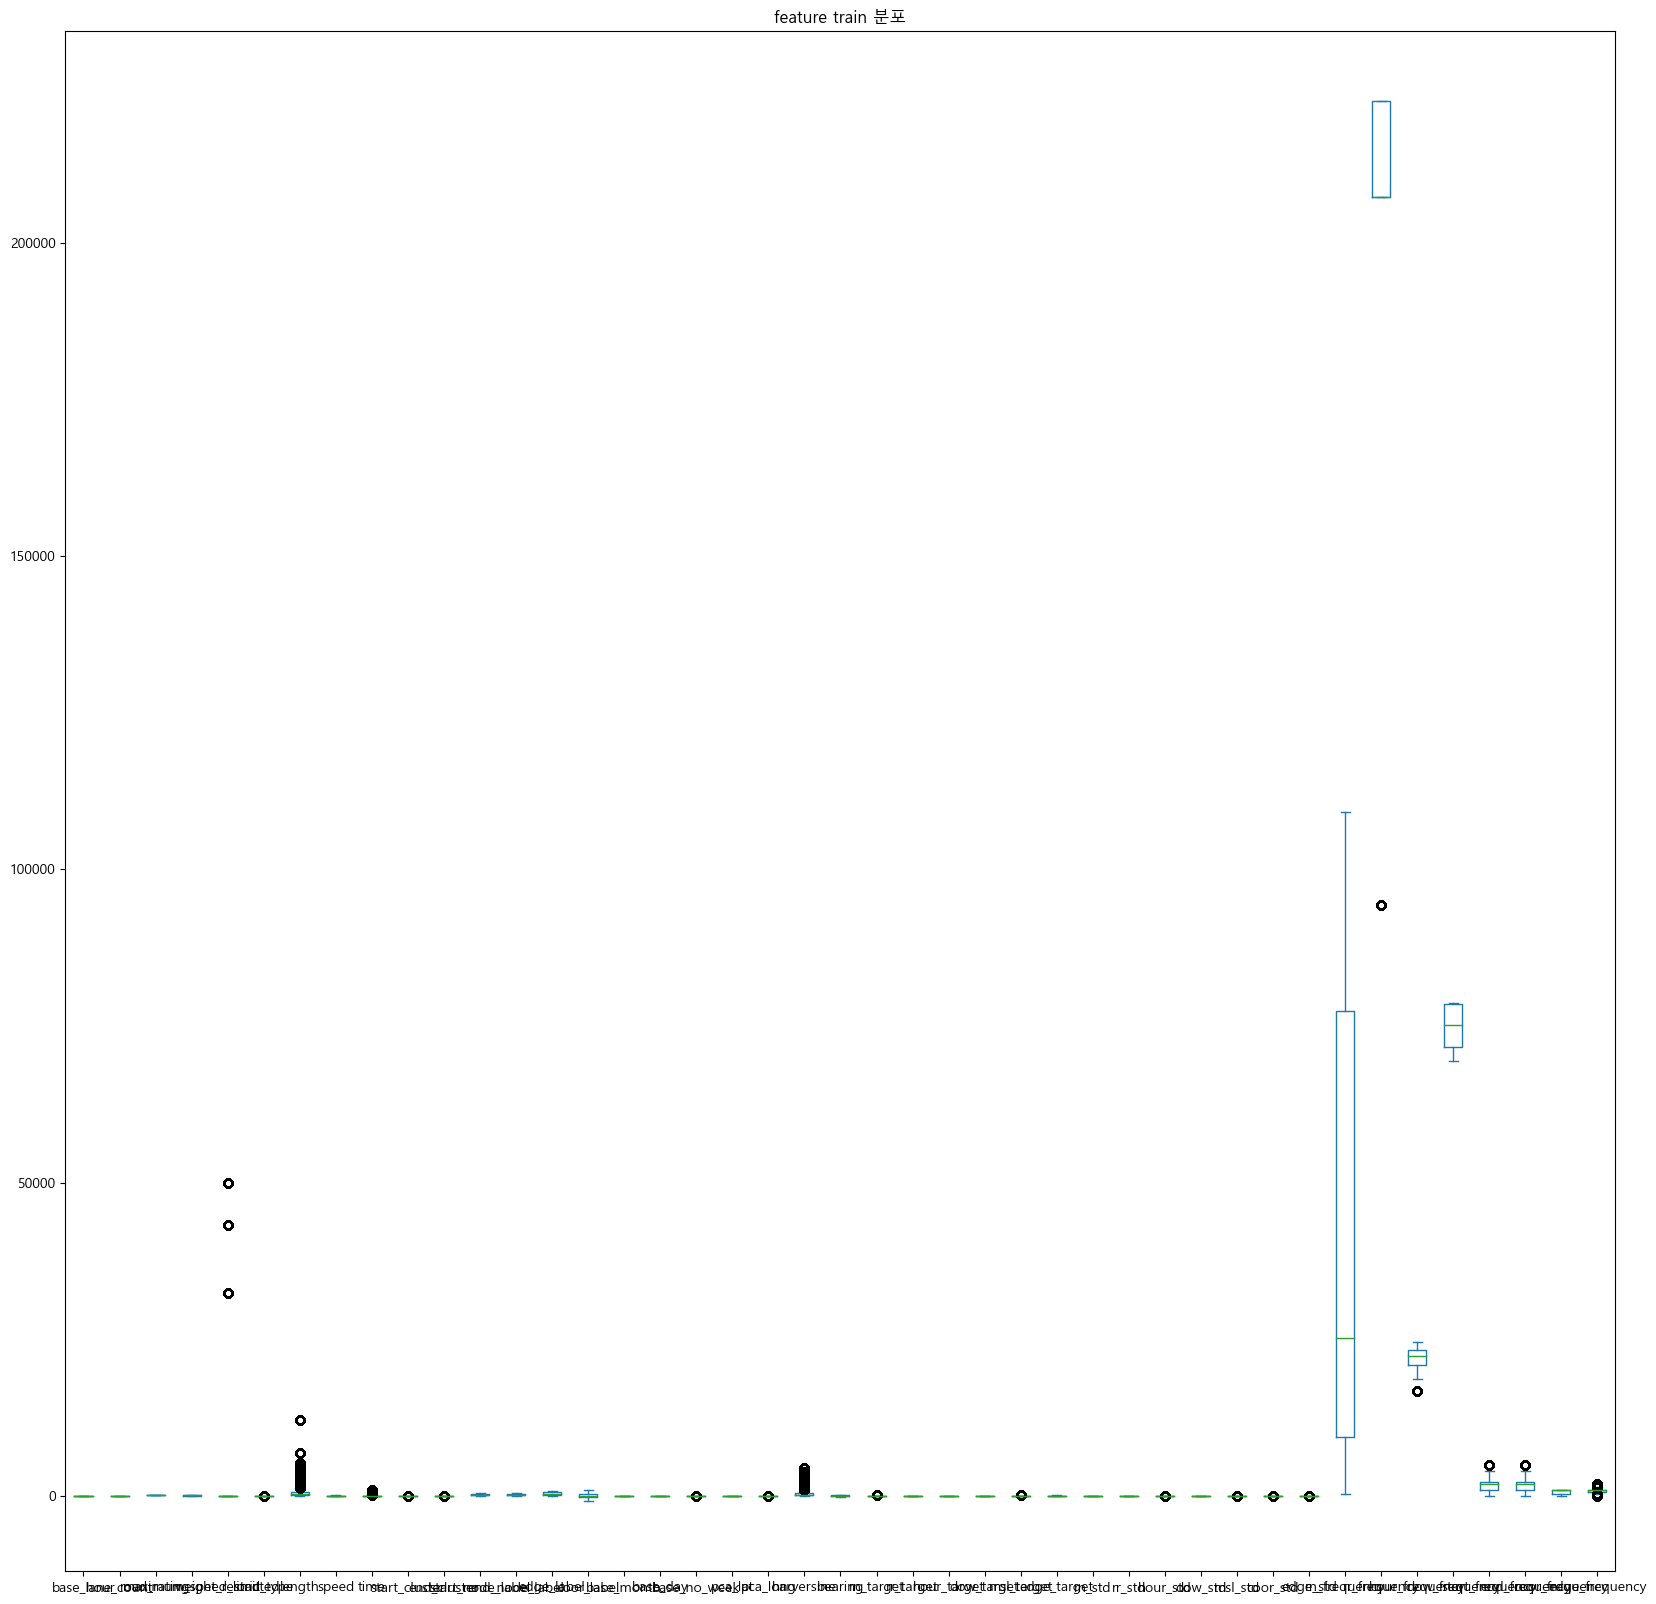

In [67]:
num = [i for i in feature_train.columns if i not in cat+['id','target']]

feature_train[num].plot.box(title="feature train 분포", figsize=(20,20))
plt.show()

In [68]:
# power, normalizer, robust 등 시도
scaler = PowerTransformer()
feature_train[num] = scaler.fit_transform(feature_train[num])
feature_test[num] = scaler.transform(feature_test[num])

- #### [Selection] Use Feature<br>
LGBM을 기준모델로 두고 학습시킨 뒤 Feature Importance를 바탕으로 Feedback하며 사용할 최종 Feature를 정한다.

In [69]:
# 선택한 Feature들을 다시 부르기 위해 저장한다.
raw_feature_train, raw_feature_test = feature_train.copy(), feature_test.copy()

In [70]:
# 기준모델에 input하고 검증할 수 있도록 데이터를 나눈다.
del feature_train['id'], feature_test['id']

y_train = feature_train['target'] ; del feature_train['target']
X_train, X_test = feature_train, feature_test
print('X_train.shape:', X_train.shape, 'X_test.shape', X_test.shape)

X_train.shape: (524074, 47) X_test.shape (291241, 47)


In [71]:
def select_feature(X_train, y_train, DEFAULT):
    # 모델을 평가할 기초값 지정
    past_score = DEFAULT
    redefine_total = []
    while True:
        train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.3, random_state=2022)
        model = LGBMRegressor(n_estimators=1000, metric= 'mae', random_state = 2022)
        model.fit(train_X, train_y)
        present_score = mean_absolute_error(val_y, model.predict(val_X))
        if present_score < past_score:
            past_score = present_score
            FI = pd.DataFrame({'Feature_Importances':model.feature_importances_})
            limit = round(FI.value_counts().sort_index().index[1][0], 6)            
            redefine = FI.query('Feature_Importances > @limit').index
            X_train = X_train.iloc[:, redefine]
            redefine_total += [redefine.tolist()]
        else:
            break
            
    train, test = raw_feature_train.copy(), raw_feature_test.copy()
    del train['id'], train['target'], test['id']
    for COLS in redefine_total:
        train, test = train.iloc[:, COLS], test.iloc[:, COLS]
        
    return train, test

In [72]:
# 최종 Feature를 지정한다.
X_train, X_test = select_feature(X_train, y_train, 4)

In [73]:
# 사용할 Feature는 저장한다.
date = str(pd.Timestamp.now())[:16].replace('-','').replace(' ','_').replace(':','')
pd.concat([raw_feature_train[['id','target']], X_train], axis=1).to_csv(f'./data/feature/train_{date}.csv', index=False)
pd.concat([raw_feature_test['id'], X_test], axis=1).to_csv(f'./data/feature/test_{date}.csv', index=False)

In [74]:
# 불필요한 변수는 삭제한다.
del raw_feature_train, raw_feature_test

### 4. Modeling

In [75]:
# model input data size
print('X_train.shape:', X_train.shape, 'X_test.shape', X_test.shape)
print('feature:', X_train.columns)

X_train.shape: (524074, 44) X_test.shape (291241, 44)
feature: Index(['day_of_week', 'base_hour', 'lane_count', 'road_rating', 'road_name',
       'maximum_speed_limit', 'weight_restricted', 'road_type',
       'start_turn_restricted', 'end_turn_restricted', 'length', 'speed',
       'time', 'start_cluster', 'end_cluster', 'start_node_label',
       'end_node_label', 'edge_label', 'coor_label', 'base_month', 'base_day',
       'base_no_week', 'pca_lat', 'pca_long', 'harversine', 'bearing',
       'rn_target', 'hour_target', 'dow_target', 'msl_target', 'edge_target',
       'rn_std', 'hour_std', 'dow_std', 'msl_std', 'coor_std', 'edge_std',
       'rn_frequency', 'hour_frequency', 'dow_frequency', 'start_frequency',
       'end_frequency', 'coor_frequency', 'edge_frequency'],
      dtype='object')


In [76]:
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.2, shuffle=False, random_state=2022)

- #### LGBM

In [77]:
lgbm_reg = LGBMRegressor(n_estimators=2000, metric= 'mae', random_state = 2022)

In [78]:
fit_params={"early_stopping_rounds":1000, 
            "eval_metric" : 'mae', 
            "eval_set" : [(val_X, val_y)],
            'verbose': 1,
            'categorical_feature': ['day_of_week', 'road_rating', 'maximum_speed_limit']}

In [79]:
lgbm_reg.fit(train_X, train_y, **fit_params)

[1]	valid_0's l1: 11.7983
[2]	valid_0's l1: 10.7826
[3]	valid_0's l1: 9.87739
[4]	valid_0's l1: 9.07781
[5]	valid_0's l1: 8.37264
[6]	valid_0's l1: 7.74719
[7]	valid_0's l1: 7.19812
[8]	valid_0's l1: 6.71339
[9]	valid_0's l1: 6.28977
[10]	valid_0's l1: 5.91306
[11]	valid_0's l1: 5.59265
[12]	valid_0's l1: 5.3104
[13]	valid_0's l1: 5.06619
[14]	valid_0's l1: 4.86022
[15]	valid_0's l1: 4.67727
[16]	valid_0's l1: 4.51941
[17]	valid_0's l1: 4.38535
[18]	valid_0's l1: 4.26793
[19]	valid_0's l1: 4.16546
[20]	valid_0's l1: 4.07745
[21]	valid_0's l1: 4.00556
[22]	valid_0's l1: 3.93903
[23]	valid_0's l1: 3.87966
[24]	valid_0's l1: 3.83249
[25]	valid_0's l1: 3.79227
[26]	valid_0's l1: 3.75424
[27]	valid_0's l1: 3.72262
[28]	valid_0's l1: 3.69544
[29]	valid_0's l1: 3.66786
[30]	valid_0's l1: 3.6444
[31]	valid_0's l1: 3.62429
[32]	valid_0's l1: 3.60704
[33]	valid_0's l1: 3.59258
[34]	valid_0's l1: 3.57603
[35]	valid_0's l1: 3.56039
[36]	valid_0's l1: 3.54922
[37]	valid_0's l1: 3.53652
[38]	valid_0

[312]	valid_0's l1: 3.12058
[313]	valid_0's l1: 3.11959
[314]	valid_0's l1: 3.11868
[315]	valid_0's l1: 3.11724
[316]	valid_0's l1: 3.1164
[317]	valid_0's l1: 3.11625
[318]	valid_0's l1: 3.11558
[319]	valid_0's l1: 3.11486
[320]	valid_0's l1: 3.11429
[321]	valid_0's l1: 3.11397
[322]	valid_0's l1: 3.11288
[323]	valid_0's l1: 3.11206
[324]	valid_0's l1: 3.11186
[325]	valid_0's l1: 3.11073
[326]	valid_0's l1: 3.10975
[327]	valid_0's l1: 3.10934
[328]	valid_0's l1: 3.10845
[329]	valid_0's l1: 3.10785
[330]	valid_0's l1: 3.10736
[331]	valid_0's l1: 3.10709
[332]	valid_0's l1: 3.10639
[333]	valid_0's l1: 3.10552
[334]	valid_0's l1: 3.10456
[335]	valid_0's l1: 3.10445
[336]	valid_0's l1: 3.10429
[337]	valid_0's l1: 3.10383
[338]	valid_0's l1: 3.10324
[339]	valid_0's l1: 3.10265
[340]	valid_0's l1: 3.10208
[341]	valid_0's l1: 3.102
[342]	valid_0's l1: 3.10141
[343]	valid_0's l1: 3.10089
[344]	valid_0's l1: 3.10056
[345]	valid_0's l1: 3.0996
[346]	valid_0's l1: 3.09919
[347]	valid_0's l1: 3.09

[614]	valid_0's l1: 3.00355
[615]	valid_0's l1: 3.00341
[616]	valid_0's l1: 3.00301
[617]	valid_0's l1: 3.00248
[618]	valid_0's l1: 3.00215
[619]	valid_0's l1: 3.00194
[620]	valid_0's l1: 3.0014
[621]	valid_0's l1: 3.00102
[622]	valid_0's l1: 3.00085
[623]	valid_0's l1: 3.00042
[624]	valid_0's l1: 3.00026
[625]	valid_0's l1: 2.99992
[626]	valid_0's l1: 2.99952
[627]	valid_0's l1: 2.99935
[628]	valid_0's l1: 2.9991
[629]	valid_0's l1: 2.9984
[630]	valid_0's l1: 2.99803
[631]	valid_0's l1: 2.99753
[632]	valid_0's l1: 2.99731
[633]	valid_0's l1: 2.99724
[634]	valid_0's l1: 2.9972
[635]	valid_0's l1: 2.99709
[636]	valid_0's l1: 2.99694
[637]	valid_0's l1: 2.99686
[638]	valid_0's l1: 2.99632
[639]	valid_0's l1: 2.99589
[640]	valid_0's l1: 2.99574
[641]	valid_0's l1: 2.9954
[642]	valid_0's l1: 2.99495
[643]	valid_0's l1: 2.99485
[644]	valid_0's l1: 2.99418
[645]	valid_0's l1: 2.99401
[646]	valid_0's l1: 2.99388
[647]	valid_0's l1: 2.9937
[648]	valid_0's l1: 2.99332
[649]	valid_0's l1: 2.9932

[916]	valid_0's l1: 2.93368
[917]	valid_0's l1: 2.93343
[918]	valid_0's l1: 2.93346
[919]	valid_0's l1: 2.93314
[920]	valid_0's l1: 2.93285
[921]	valid_0's l1: 2.93258
[922]	valid_0's l1: 2.93221
[923]	valid_0's l1: 2.93202
[924]	valid_0's l1: 2.93193
[925]	valid_0's l1: 2.93189
[926]	valid_0's l1: 2.93176
[927]	valid_0's l1: 2.93177
[928]	valid_0's l1: 2.93153
[929]	valid_0's l1: 2.93139
[930]	valid_0's l1: 2.93131
[931]	valid_0's l1: 2.93128
[932]	valid_0's l1: 2.93122
[933]	valid_0's l1: 2.93121
[934]	valid_0's l1: 2.93112
[935]	valid_0's l1: 2.93106
[936]	valid_0's l1: 2.93077
[937]	valid_0's l1: 2.93077
[938]	valid_0's l1: 2.93067
[939]	valid_0's l1: 2.93057
[940]	valid_0's l1: 2.93052
[941]	valid_0's l1: 2.93039
[942]	valid_0's l1: 2.93032
[943]	valid_0's l1: 2.92989
[944]	valid_0's l1: 2.92967
[945]	valid_0's l1: 2.92937
[946]	valid_0's l1: 2.9293
[947]	valid_0's l1: 2.92914
[948]	valid_0's l1: 2.92903
[949]	valid_0's l1: 2.92899
[950]	valid_0's l1: 2.92898
[951]	valid_0's l1: 2

[1209]	valid_0's l1: 2.89597
[1210]	valid_0's l1: 2.89589
[1211]	valid_0's l1: 2.89533
[1212]	valid_0's l1: 2.89521
[1213]	valid_0's l1: 2.89509
[1214]	valid_0's l1: 2.89492
[1215]	valid_0's l1: 2.89489
[1216]	valid_0's l1: 2.89477
[1217]	valid_0's l1: 2.89478
[1218]	valid_0's l1: 2.89475
[1219]	valid_0's l1: 2.89439
[1220]	valid_0's l1: 2.89426
[1221]	valid_0's l1: 2.89422
[1222]	valid_0's l1: 2.89418
[1223]	valid_0's l1: 2.89419
[1224]	valid_0's l1: 2.89404
[1225]	valid_0's l1: 2.89384
[1226]	valid_0's l1: 2.89386
[1227]	valid_0's l1: 2.89358
[1228]	valid_0's l1: 2.89332
[1229]	valid_0's l1: 2.89286
[1230]	valid_0's l1: 2.89285
[1231]	valid_0's l1: 2.89263
[1232]	valid_0's l1: 2.89252
[1233]	valid_0's l1: 2.89242
[1234]	valid_0's l1: 2.89242
[1235]	valid_0's l1: 2.89239
[1236]	valid_0's l1: 2.89232
[1237]	valid_0's l1: 2.89198
[1238]	valid_0's l1: 2.89188
[1239]	valid_0's l1: 2.89165
[1240]	valid_0's l1: 2.89158
[1241]	valid_0's l1: 2.89146
[1242]	valid_0's l1: 2.89138
[1243]	valid_0

[1516]	valid_0's l1: 2.86244
[1517]	valid_0's l1: 2.86222
[1518]	valid_0's l1: 2.86213
[1519]	valid_0's l1: 2.86191
[1520]	valid_0's l1: 2.86182
[1521]	valid_0's l1: 2.86166
[1522]	valid_0's l1: 2.86164
[1523]	valid_0's l1: 2.86146
[1524]	valid_0's l1: 2.86145
[1525]	valid_0's l1: 2.86135
[1526]	valid_0's l1: 2.86116
[1527]	valid_0's l1: 2.86111
[1528]	valid_0's l1: 2.86102
[1529]	valid_0's l1: 2.86104
[1530]	valid_0's l1: 2.86094
[1531]	valid_0's l1: 2.86094
[1532]	valid_0's l1: 2.86082
[1533]	valid_0's l1: 2.86074
[1534]	valid_0's l1: 2.8607
[1535]	valid_0's l1: 2.86044
[1536]	valid_0's l1: 2.86033
[1537]	valid_0's l1: 2.86028
[1538]	valid_0's l1: 2.86012
[1539]	valid_0's l1: 2.86012
[1540]	valid_0's l1: 2.86012
[1541]	valid_0's l1: 2.8601
[1542]	valid_0's l1: 2.85992
[1543]	valid_0's l1: 2.85987
[1544]	valid_0's l1: 2.85979
[1545]	valid_0's l1: 2.85959
[1546]	valid_0's l1: 2.85946
[1547]	valid_0's l1: 2.85943
[1548]	valid_0's l1: 2.85932
[1549]	valid_0's l1: 2.85917
[1550]	valid_0's

[1804]	valid_0's l1: 2.84018
[1805]	valid_0's l1: 2.84012
[1806]	valid_0's l1: 2.84006
[1807]	valid_0's l1: 2.83998
[1808]	valid_0's l1: 2.84001
[1809]	valid_0's l1: 2.83991
[1810]	valid_0's l1: 2.83989
[1811]	valid_0's l1: 2.83979
[1812]	valid_0's l1: 2.8397
[1813]	valid_0's l1: 2.83961
[1814]	valid_0's l1: 2.83956
[1815]	valid_0's l1: 2.83953
[1816]	valid_0's l1: 2.83952
[1817]	valid_0's l1: 2.8395
[1818]	valid_0's l1: 2.83953
[1819]	valid_0's l1: 2.83956
[1820]	valid_0's l1: 2.83958
[1821]	valid_0's l1: 2.83944
[1822]	valid_0's l1: 2.8393
[1823]	valid_0's l1: 2.83918
[1824]	valid_0's l1: 2.83906
[1825]	valid_0's l1: 2.83892
[1826]	valid_0's l1: 2.8389
[1827]	valid_0's l1: 2.83883
[1828]	valid_0's l1: 2.83879
[1829]	valid_0's l1: 2.83872
[1830]	valid_0's l1: 2.83871
[1831]	valid_0's l1: 2.83868
[1832]	valid_0's l1: 2.83859
[1833]	valid_0's l1: 2.83854
[1834]	valid_0's l1: 2.83848
[1835]	valid_0's l1: 2.83847
[1836]	valid_0's l1: 2.83845
[1837]	valid_0's l1: 2.83828
[1838]	valid_0's l

LGBMRegressor(metric='mae', n_estimators=2000, random_state=2022)

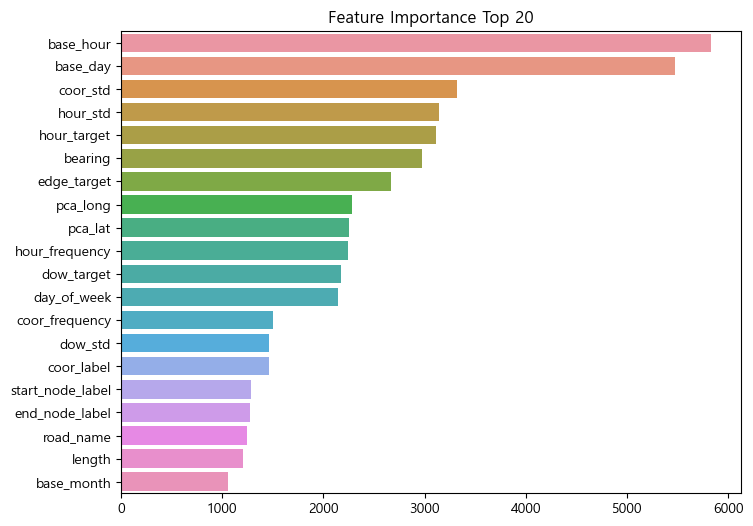

In [80]:
# LGBM의 Feature Importance
ft_importance_values = lgbm_reg.feature_importances_
ft_series = pd.Series(ft_importance_values, index = X_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

- #### CatBoost
```python
cat_params = {'iterations':1000,
              'eval_metric':'MAE',
              'bootstrap_type':'Bayesian',
              'cat_features':['day_of_week', 'road_rating','connect_code', 'maximum_speed_limit',
                              'weight_restricted', 'road_type', 'start_turn_restricted', 'end_turn_restricted'],
              'random_state':2022, 'task_type':"GPU"}
cat_reg = CatBoostRegressor(**cat_params)
cat_reg.fit(train_X, train_y)
# Catboost의 Feature Importance
ft_importance_values = cat_reg.feature_importances_
ft_series = pd.Series(ft_importance_values, index = X_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()
```

### Submit

In [81]:
# 사용할 모델로 예측한 뒤 저장한다.
sample['target'] = lgbm_reg.predict(X_test)
date = str(pd.Timestamp.now())[:16].replace('-','').replace(' ','_').replace(':','')
sample.to_csv(f'./data/submission/{date}.csv', index=False)

In [82]:
sample

,id,target
0,TEST_000000,23.811073
1,TEST_000001,43.753994
2,TEST_000002,65.666189
3,TEST_000003,38.648504
4,TEST_000004,43.394177
...,...,...
291236,TEST_291236,48.238735
291237,TEST_291237,51.141192
291238,TEST_291238,22.763800
291239,TEST_291239,22.787113
